In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import yaml

import xarray as xr
import cartopy
import cartopy.crs as ccrs
from pyresample import geometry, load_area

In [2]:
areas_filepath =  '../dataset/downloads/files/areas.yaml'
area_def = load_area(areas_filepath, 'full_disk')

area_file = open(areas_filepath)
parsed_area_file = yaml.load(area_file, Loader=yaml.FullLoader)
area_dict_full_disk = parsed_area_file['full_disk']
area_dict_region = parsed_area_file['region']
area_file.close()

region_corners = area_dict_region['area_extent']
region_width = area_dict_region['width']
region_height = area_dict_region['height']
shape_full_disk = area_dict_full_disk['shape']


In [3]:
# Create image boxes
projcoords_x, projcoords_y = area_def.get_proj_vectors()

projcoords_y_diff = np.abs(projcoords_y - region_corners[3])
projcoords_x_diff = np.abs(projcoords_x - region_corners[0])

edge_ind_y = np.argmin(projcoords_y_diff)
edge_ind_x = np.argmin(projcoords_x_diff)


In [4]:
covered_hist = np.zeros((region_width, region_height))

In [5]:
covered_hist.shape

(1024, 1024)

In [6]:
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.read())
f.close() 

In [8]:
#centers = []
for root, dirs, files in os.walk(os.path.join(path_to_dataset,'origin')):
    #print(root)
    for name in files:
        dataset = xr.open_dataset(os.path.join(root, name))
        dataset.close()
        #area_ext = dataset.area_extent
        #center = [np.mean([area_ext[0],area_ext[2]]), np.mean([area_ext[1],area_ext[3]])]
        #centers.append(center)
        ind_ext = dataset.ind_extent
        indx_low, indy_high, indx_high, indy_low = ind_ext
        indx_low = indx_low - edge_ind_x
        indx_high = indx_high - edge_ind_x
        indy_low = indy_low - edge_ind_y
        indy_high = indy_high - edge_ind_y
        covered_hist[indx_low:indx_high, indy_low:indy_high] += np.ones((indx_high-indx_low, indy_high-indy_low))

In [ ]:
#centers_df = pd.DataFrame(centers, columns = ['x', 'y'])

In [ ]:
#plt.imshow(covered_hist)

Heatmap of where data is collected

/home/ingrid/anaconda/envs/geostat/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/ingrid/anaconda/envs/geostat/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


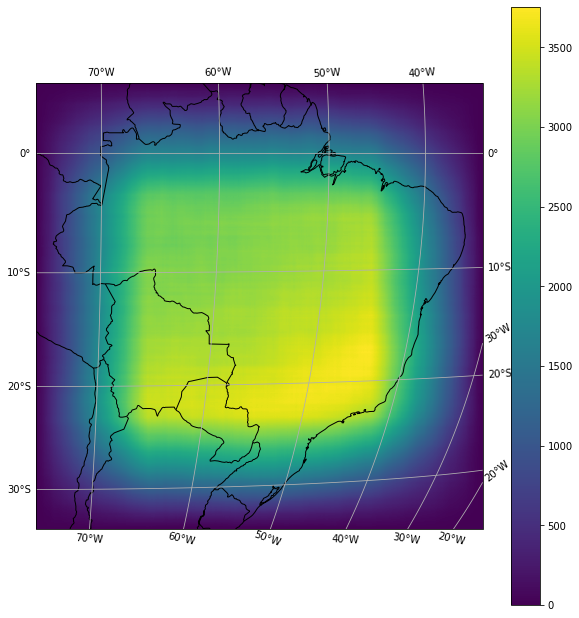

In [9]:
area_def_region = area_def.copy(area_extent = region_corners, height = region_height, width = region_width)
crs = area_def_region.to_cartopy_crs()

fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize = (10,11))

#ax.scatter(centers_df.x,centers_df.y, transform=crs, s=20, color='#64a6a1')
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)
#ax.set_global()
#ax.title.set_text(plot_title)
im = ax.imshow(covered_hist,  transform=crs, extent=crs.bounds, vmin=0.0, vmax = np.max(covered_hist))
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.colorbar(im)

plt.show()